Test kernel and mmd on binomial graphs

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification')
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification/myKernels')
from myKernels import RandomWalk as rw
#from importlib import reload
#reload(readfoldertopanda)
import importlib
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
import WL
import GNTK
import GraphStatKernel
import WWL

Generate graphs

In [13]:
from importlib import reload  
foo = reload(mg)

n_1 = 60
n_2 = 60
nnode_1 = 40
nnode_2 = 40

p = [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)]
q = [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2)  for i in range(n_2)]#[np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)] # [np.ones(nnode_1) for i in range(n_1)] + [np.ones(nnode_2) for i in range(n_2)]

6.4489
4.805
bg1 = mg.BinomialGraphs(n_1, nnode_1, k = 4.5, fullyConnected = True, l = 'degreelabels')
bg2 = mg.BinomialGraphs(n_2, nnode_2, k = 4, fullyConnected = True, l = 'degreelabels')
bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

In [5]:
def issymmetric(a, rtol=1e-05, atol=1e-08):
    """
    Check if matrix is symmetric
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [14]:
importlib.reload(sys.modules['MMDforGraphs'])
import tqdm
mmdu = []
for sample in range(1): #tqdm.tqdm(range(1)):

    # Gs_mst = []
    # for G in Gs:
    #     Gs_mst.append(nx.minimum_spanning_tree(G))
    # Gs = Gs_mst
    bg1.Generate()
    bg2.Generate()
    Gs = bg1.Gs + bg2.Gs

    # Grakel kernels
    graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
    # kernel = [{"name": "multiscale_laplacian"}]
    # K = mg.KernelMatrix(graph_list, kernel, False)   
    kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "vertex_histogram"}]
    # kernel = [{"name": "WL-OA", "n_iter": 4}]
    #kernel = [{"name": "SP", "with_labels": 1}]
    #kernel = [{"name": "graphlet_sampling", "k": 3, 'sampling':{'epsilon':0.05}}]
    # kernel = [{"name": "lovasz_theta", "n_samples":20}]
    #kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
    # kernel = [{"name": "pyramid_match", "with_labels":False, "d":2, "L":4}] 
    #kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
    # kernel = [{"name":'odd_sth', 'h':3}]
    #kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "propagation", "t_max": 2, "w":0.01, "M":'TV'}]

    init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
    K = init_kernel.fit_transform(graph_list)

    # My kernels
    # RW kernel
    # label list for rw
    # label_list = []
    # for G in Gs:
    #     label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

    # label_list = np.unique(np.concatenate(label_list))
    # rw_kernel = rw.RandomWalk(Gs, c = 0.01, normalize=0, p = p, q = q)
    # K = rw_kernel.fit_ARKL(r = 8, label_list = label_list, normalize_adj=True)
    # K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False, verbose=False)
    # K = rw_kernel.fit_random_walk(mu_vec=[0.0, 1.0/(nnode_1*nnode_2)], k = 1, r = 3, normalize_adj=False ) # 1/((nnode_1-1)*(nnode_2-1)))

    #print(np.all(K == 0)) 
    #print(K)

    #gntk = GNTK.GNTK(num_layers=2, num_mlp_layers=2, jk=True, scale='degree', normalize=False)
    #gntk.preprocess(Gs, degree_as_tag = True)
    #K = gntk.fit_all()

    #gstat = GraphStatKernel.G_stat_kernel()
    #K = gstat.fit(Gs, method = 'degree', kernel_width= 100)

    #kernel = WWL.WWL(param = {'discount':0.1,'h':3, 'sinkhorn':False })
    #K = kernel.fit_transform(Gs)


    MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = bg1.n, m = bg1.n  ), 
                        dict(n = bg1.n, m = bg1.n ),
                        dict(n = bg1.n, m = bg1.n )]#, 
                        #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]
                        #dict(Q = 3, y1 = list(range(bg1.n)), y2 = list(range(bg1.n, bg1.n+bg2.n)) )]
    kernel_hypothesis.Bootstrap(K, function_arguments, B = 3000)

    # Run power
    threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.05)
    #print(f'threshold {threshold}')
    ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], threshold, n_1)
    #print(f'V {V}')
    #print(f'ratio {ratio}')
    #print(f'power {power}')
    print(f'p_value {kernel_hypothesis.p_values}')
    #print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

    mmdu.append(kernel_hypothesis.p_values['MMD_u'])
    print(power)

p_value {'MMD_b': 0.0, 'MMD_u': 0.0, 'MMD_l': 0.004}
0.6796641885681071


Text(0.5, 1.0, '$H_0$ True')

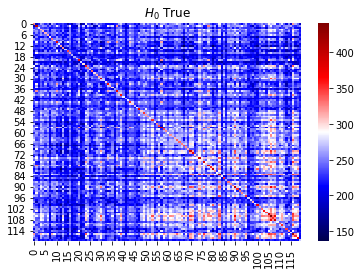

In [15]:
#np.fill_diagonal(K,0)
ax = plt.axes()
sns.heatmap(K, cmap='seismic')

ax.set_title(fr'$H_0$ True')